In [1]:
import warnings
import pathlib
from datetime import datetime, timedelta
import multiprocessing

import numpy as np
import pandas as pd
import xarray as xr
import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colorbar import ColorbarBase
from matplotlib import patches

import intake
import healpy


In [2]:
xr.open_dataset(
    "/scratch/b/b382635/tobac_tracks/amazon/20210707/tobac_20210707T0000_20210708T0000_system_mask_linked.nc"
)

<xarray.Dataset> Size: 32GB
Dimensions:              (time: 96, level_full: 50, lat: 300, lon: 400)
Coordinates:
  * time                 (time) datetime64[ns] 768B 2021-07-07 ... 2021-07-07...
  * level_full           (level_full) int32 200B 41 42 43 44 45 ... 87 88 89 90
  * lat                  (lat) float64 2kB -15.0 -14.9 -14.8 ... 14.7 14.8 14.9
  * lon                  (lon) float64 3kB -83.0 -82.9 -82.8 ... -43.2 -43.1
Data variables:
    convective           (time, level_full, lat, lon) float64 5GB ...
    updraft_features     (time, level_full, lat, lon) float64 5GB ...
    convective_features  (time, level_full, lat, lon) float64 5GB ...
    anvil_features       (time, level_full, lat, lon) float64 5GB ...
    system               (time, level_full, lat, lon) float64 5GB ...
    core                 (time, level_full, lat, lon) float64 5GB ...
    anvil                (time, level_full, lat, lon) float64 5GB ...

In [5]:
def plot_a_timestep(t: str | np.datetime64):
    if isinstance(t, str):
        t = np.datetime64(t, "ns")
    
    # First, load the tracked features dataset:
    features_path = pathlib.Path("/scratch/b/b382635/tobac_tracks/amazon/")
    
    date = datetime.strptime(str(t.astype("datetime64[s]")), "%Y-%m-%dT%H:%M:%S")
    
    features_file = sorted(list((features_path / date.strftime("%Y%m%d")).glob("*_system_mask_linked.nc")))
    print(features_file)
    if len(features_file):
        ds = xr.open_dataset(features_file[0]).isel(lat=slice(200, None), lon=slice(30,150))
        print(ds.lat.size, ds.lon.size)
    else:
        raise ValueError("No track file detected")

    # Second, load the icon 3d dataset as dask:
    cat = intake.open_catalog(
        '/work/bm1235/k203123/nextgems_prefinal/experiments/ngc4008a/outdata/ngc4008a.yaml'
    )
    ds_icon = cat.ngc4008a(chunks="auto", zoom=9, time='PT15M').to_dask()
    
    # For regridding later
    pix = xr.DataArray(
        healpy.ang2pix(ds_icon.crs.healpix_nside, *np.meshgrid(ds.lon, ds.lat), nest=True, lonlat=True),
        coords=(ds.lat, ds.lon),
    )

    # Third, load background image and crop
    bg_image = plt.imread("/home/b/b382728/data/world.200407.3x21600x10800.png")
    
    img_lat_bounds = [ds.lat[0].item()-0.05, ds.lat[-1].item()+0.05]
    img_lon_bounds = [ds.lon[0].item()-0.05, ds.lon[-1].item()+0.05]
    
    img_y_bounds = [int(np.round((90-lb)/180*10800)) for lb in img_lat_bounds]
    img_x_bounds = [int(np.round((lb+180)/360*21600)) for lb in img_lon_bounds]
    
    bg_image = bg_image[img_y_bounds[1]:img_y_bounds[0], img_x_bounds[0]:img_x_bounds[1]]
    
    bg_lats = np.linspace(img_lat_bounds[1], img_lat_bounds[0], bg_image.shape[0])
    bg_lons = np.linspace(img_lon_bounds[0], img_lon_bounds[1], bg_image.shape[1])

    # Now setup grids for voxel plotting
    icon_lats = np.zeros(ds.lat.size + 1)
    icon_lats[1:-1] = 0.5 * (ds.lat[:-1].values + ds.lat[1:].values)
    icon_lats[0] = ds.lat[0].item() - 0.05
    icon_lats[-1] = ds.lat[-1].item() + 0.05
    
    icon_lons = np.zeros(ds.lon.size + 1)
    icon_lons[1:-1] = 0.5 * (ds.lon[:-1].values + ds.lon[1:].values)
    icon_lons[0] = ds.lon[0].item() + 0.05
    icon_lons[-1] = ds.lon[-1].item() - 0.05
    
    vox_h = np.zeros(icon_lats.shape + icon_lons.shape + (51,))
    vox_h[:-1,:-1] = ds_icon.zghalf.isel(level_half=slice(40, None), cell=pix).values.transpose([1,2,0])
    vox_h[1:,1:] += vox_h[:-1,:-1]
    vox_h[1:-1,1:-1] *= 0.5
    vox_h /= 1e3 # convert to km
    
    vox_lats, vox_lons = np.meshgrid(icon_lats, icon_lons, indexing="ij")
    vox_lats = np.stack([vox_lats] * vox_h.shape[-1], axis=-1)
    vox_lons = np.stack([vox_lons] * vox_h.shape[-1], axis=-1)

    # colormaps for plotting
    cli_cmap = plt.cm.Blues(np.linspace(0,1,256))
    cli_cmap[:,-1] = np.linspace(0,1,256)
    cli_cmap = ListedColormap(cli_cmap)
    
    clw_cmap = plt.cm.Greys(np.linspace(0,0.5,256))
    clw_cmap[:,-1] = np.linspace(0,1,256)
    clw_cmap = ListedColormap(clw_cmap)
    
    precip_cmap = plt.cm.RdPu(np.linspace(0,1,256))
    precip_cmap[:,-1] = np.linspace(0,1,256)
    precip_cmap = ListedColormap(precip_cmap)

    # Start processing time step
    ds_icon_t = ds_icon.sel(time=t).drop_vars(["zghalf", "zg"])
    
    cli = ds_icon_t.cli.sel(level_full=ds.level_full, cell=pix).values.transpose([1,2,0])
    clw = ds_icon_t.clw.sel(level_full=ds.level_full, cell=pix).values.transpose([1,2,0])
    precip = (
        ds_icon_t.qg.sel(level_full=ds.level_full, cell=pix).values
        + ds_icon_t.qr.sel(level_full=ds.level_full, cell=pix).values
        + ds_icon_t.qs.sel(level_full=ds.level_full, cell=pix).values
    ).transpose([1,2,0])

    # Get voxels for condensate
    voxels = np.zeros(cli.shape)
    voxel_colours = np.zeros((4,) + cli.shape)
    voxel_colours_cli = voxel_colours.copy()
    voxel_colours_clw = voxel_colours.copy()
    voxel_colours_precip = voxel_colours.copy()
    
    voxels[cli>1e-6] = 1
    voxel_colours_cli[:, cli>1e-6] += cli_cmap(np.clip((np.log10(cli[cli>1e-6])+6)/3, 0, 1)).T
    
    voxels[clw>1e-6] = 1
    voxel_colours_clw[:, clw>1e-6] += clw_cmap(np.clip((np.log10(clw[clw>1e-6])+6)/3, 0, 1)).T
    
    voxels[precip>1e-6] = 1
    voxel_colours_precip[:, precip>1e-6] += precip_cmap(np.clip((np.log10(precip[precip>1e-6])+6)/3, 0, 1)).T
    
    voxel_colours[-1] = voxel_colours_cli[-1] + voxel_colours_clw[-1] + voxel_colours_precip[-1]
    voxel_colours[:-1] = (
        voxel_colours_cli[:-1] * voxel_colours_cli[-1] 
        + voxel_colours_clw[:-1] * voxel_colours_clw[-1] 
        + voxel_colours_precip[:-1] * voxel_colours_precip[-1]
    ) / voxel_colours[-1]
    
    voxel_colours = voxel_colours.transpose(1,2,3,0)
    voxel_colours = np.clip(voxel_colours, 0, 1)

    
    # Get voxels for labels
    label_voxels = np.zeros(ds.core.sel(time=t).shape)
    label_voxel_colours = np.zeros(label_voxels.shape + (4,)) #np.empty(label_voxels.shape, dtype=object)
    
    wh_system = ds.system.sel(time=t).values > 0
    label_voxels[wh_system] = 1
    label_voxel_colours[wh_system] = [255/255, 127/255, 14/255, 1.] #C01
    
    wh_anvil = ds.anvil.sel(time=t).values > 0
    label_voxels[wh_anvil] = 1
    label_voxel_colours[wh_anvil] = [31/255, 119/255, 180/255, 1.] #C00
    
    wh_core = ds.core.sel(time=t).values > 0
    label_voxels[wh_core] = 1
    label_voxel_colours[wh_core] = [214/255, 39/255, 40/255, 1.] #C03
    
    label_voxels = label_voxels.transpose(1,2,0)
    label_voxel_colours = label_voxel_colours.transpose(1,2,0,3)

    # Now plot
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(9.6, 4.8), dpi=150, 
        subplot_kw=dict(projection="3d", computed_zorder=False)
    )
    ax1.plot_surface(
        *np.meshgrid(bg_lats, bg_lons, indexing="ij"), 
        np.zeros(bg_image.shape[:-1]), 
        rstride=1, cstride=1, 
        facecolors=bg_image**0.6,
        zorder=0
    )
    ax1.set_xlabel("Latitude [°] ")
    ax1.set_ylabel("Longitude [°]")
    ax1.set_zlabel("Height [km]")
    ax1.invert_xaxis()
    
    ax2.plot_surface(
        *np.meshgrid(bg_lats, bg_lons, indexing="ij"), 
        np.zeros(bg_image.shape[:-1]), 
        rstride=1, cstride=1, 
        facecolors=bg_image**0.6,
        zorder=0
    )
    ax2.set_xlabel("Latitude [°]")
    ax2.set_ylabel("Longitude [°]")
    ax2.set_zlabel("Height [km]")
    ax2.invert_xaxis()
    
    clouds_vox = ax1.voxels(
        vox_lats, vox_lons, vox_h, voxels, 
        facecolors=voxel_colours,
        zorder=1
    )
    
    labels_vox = ax2.voxels(
        vox_lats, vox_lons, vox_h, label_voxels, 
        facecolors=label_voxel_colours,
        zorder=1, alpha=0.5
    )
    
    plt.subplots_adjust(wspace=0.2)
    
    ax1_bounds = list(ax1.get_position().bounds)
    ax1_bounds[0] = ax1_bounds[0] + ax1_bounds[2] * 0.1
    ax1_bounds[2] = ax1_bounds[2] * 0.9
    
    cax = fig.add_axes([ax1_bounds[0], 0.05, ax1_bounds[2], 0.025])
    cbar = ColorbarBase(cax, cmap=cli_cmap, orientation = 'horizontal')
    cbar.set_ticks(np.linspace(0,1,4), labels=["", "", "", ""])
    cbar.ax.set_ylabel("ice", rotation=0, ha="right", va="center")
    
    cax = fig.add_axes([ax1_bounds[0], 0, ax1_bounds[2], 0.025])
    cbar = ColorbarBase(cax, cmap=clw_cmap, orientation = 'horizontal')
    cbar.set_ticks(np.linspace(0,1,4), labels=["", "", "", ""])
    cbar.ax.set_ylabel("liquid", rotation=0, ha="right", va="center")
    
    cax = fig.add_axes([ax1_bounds[0], -0.05, ax1_bounds[2], 0.025])
    cbar = ColorbarBase(cax, cmap=precip_cmap, orientation = 'horizontal')
    cbar.ax.set_ylabel("hydrometeors", rotation=0, ha="right", va="center")
    cbar.set_ticks(np.linspace(0,1,4), labels=[r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$"])
    cbar.set_label(r"$\mathrm{kg \cdot kg^{-1}}$")
    
    ax2_bounds = list(ax2.get_position().bounds)
    
    fig.legend(
        [patches.Rectangle((0,0), 1, 1, fc="C03"), patches.Rectangle((0,0), 1, 1, fc="C00"), patches.Rectangle((0,0), 1, 1, fc="C01")],
        ["core", "anvil", "preconvective"],
        title="tracked features", 
        ncol=3, loc="center",
        bbox_to_anchor=(ax2_bounds[0] + 0.5 * ax2_bounds[2], 0.01)
    )
    
    ax1_bounds = list(ax1.get_position().bounds)
    
    fig.text(
        ax1_bounds[0]+0.02, ax1_bounds[1] + ax1_bounds[3], 
        f'ICON/NextGEMS cycle 4 condensate and tracked features: {str(t.astype("datetime64[s]"))}', 
        ha="left", fontsize=12
    )

    # And save
    timestr = str(t.astype("datetime64[s]")).replace("-", "").replace(":", "")
    fig.savefig(f'./3d_frames/3d_anim_frame_{timestr}.png', bbox_inches="tight", pad_inches=0.2)
    
    return fig

[PosixPath('/scratch/b/b382635/tobac_tracks/amazon/20210702/tobac_20210702T0000_20210703T0000_system_mask_linked.nc')]
<xarray.Dataset> Size: 3GB
Dimensions:              (time: 96, level_full: 50, lat: 100, lon: 120)
Coordinates:
  * time                 (time) datetime64[ns] 768B 2021-07-02 ... 2021-07-02...
  * level_full           (level_full) int32 200B 41 42 43 44 45 ... 87 88 89 90
  * lat                  (lat) float64 800B 5.0 5.1 5.2 5.3 ... 14.7 14.8 14.9
  * lon                  (lon) float64 960B -80.0 -79.9 -79.8 ... -68.2 -68.1
Data variables:
    convective           (time, level_full, lat, lon) float64 461MB ...
    updraft_features     (time, level_full, lat, lon) float64 461MB ...
    convective_features  (time, level_full, lat, lon) float64 461MB ...
    anvil_features       (time, level_full, lat, lon) float64 461MB ...
    system               (time, level_full, lat, lon) float64 461MB ...
    core                 (time, level_full, lat, lon) float64 461MB ...
   

/home/b/b382728/miniconda3/envs/tobac/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/tmp/ipykernel_1825752/2105480879.py:106: RuntimeWarning: invalid value encountered in divide
  voxel_colours[:-1] = (


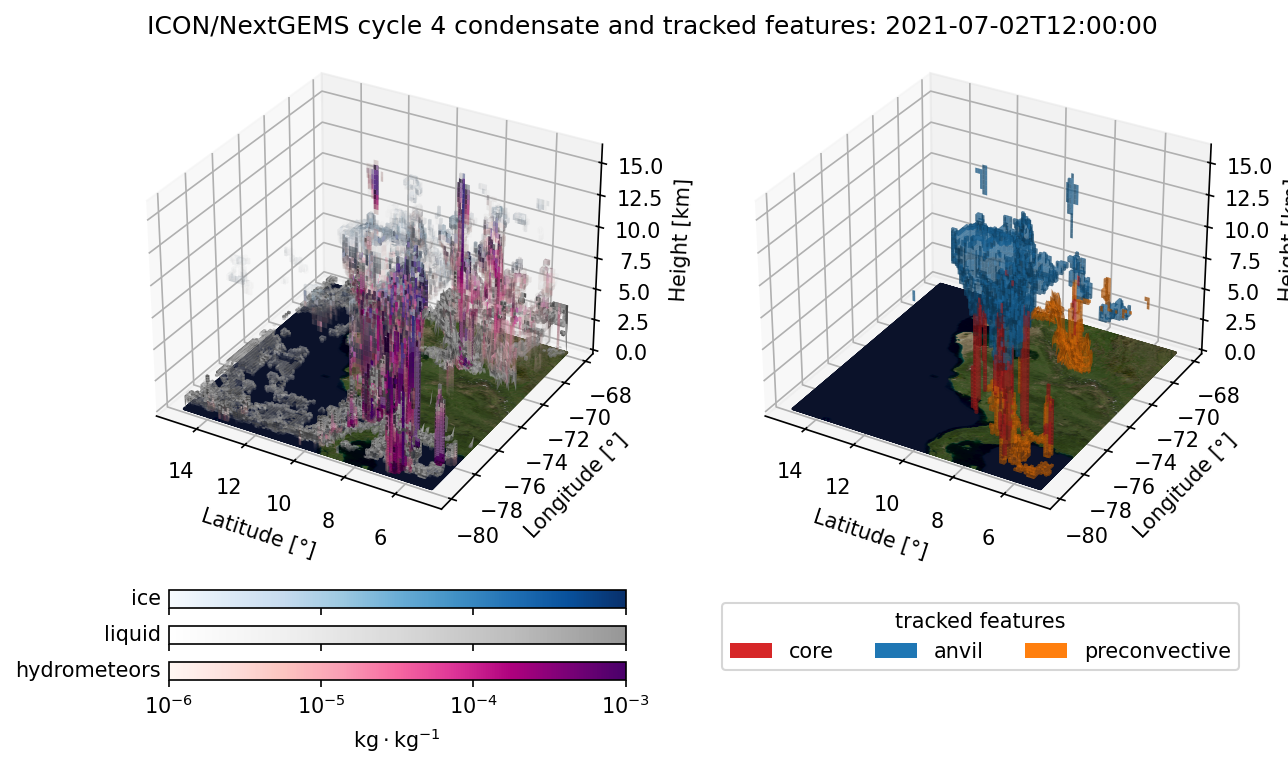

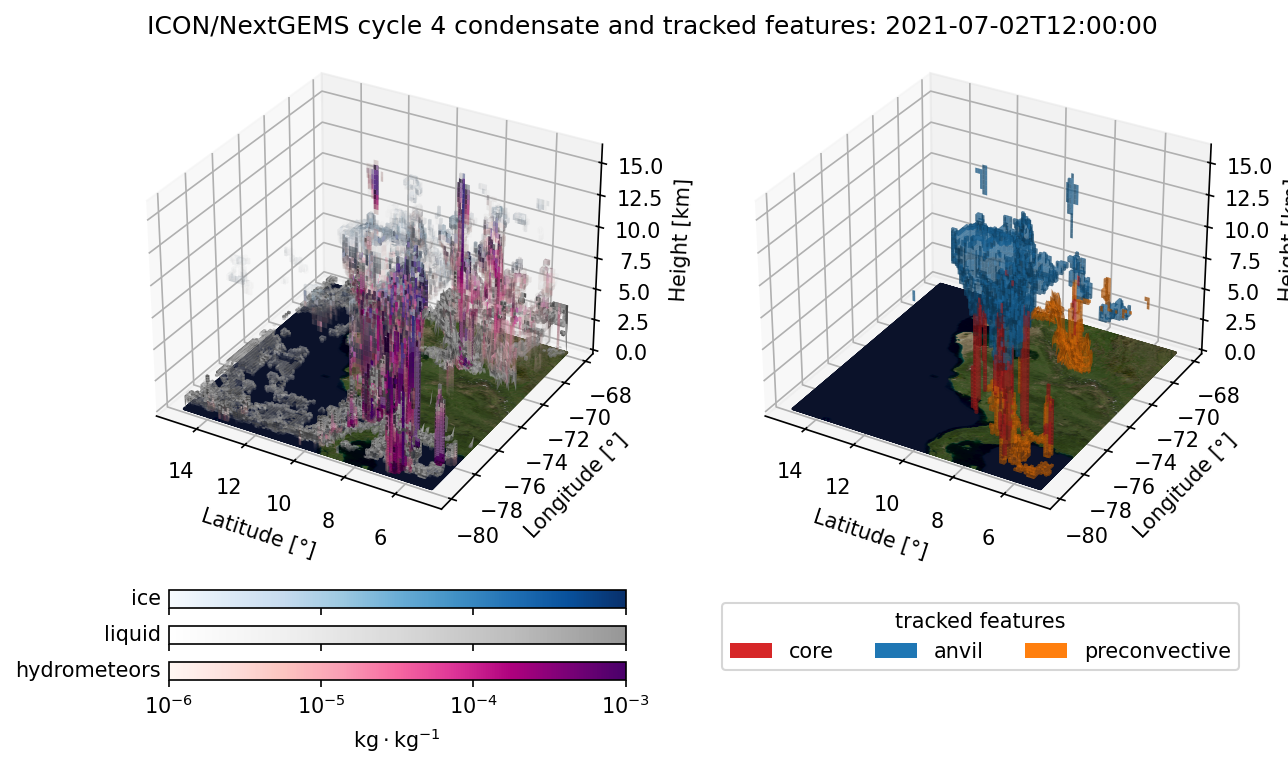

In [6]:
plot_a_timestep("2021-07-02T12:00:00")